<font size="4">
Use this training notebook to train UNet_lite from: <br> 
<code><font size="3.5">
Models/model_for_hls.py <br>
</font></code> as it works with its different architecture and functional API. <br><br>
Change as required for your setup:
<ul>
  <li><code>gpu = gpus[#GPU]</code> Choose #GPU to run training on, can copy and paste notebook and train on different GPUs simultaneously</li>
  <li><code>num_events = </code> How many events to load to .npy and/or train on</li>
  <li><code>dataset = Dataset(..., save = True/False,...</code> Use True for 1st run through to create .npy files, False after </li>
  <li><code>gpu = gpus[#GPU]</code> Choose #GPU to run training on, can copy and paste notebook and train on different GPUs simultaneously</li>
  <li><code>output_dir= </code>set where you want your trained model to be saved</li>
  <li><code>modtype = </code> Choose from either 'UNet_lite' or 'UNet2d'</li>
  <li><code>strip_size = </code> Choose from either 'strip' or 'full_image'</li>
</ul>
</font>

In [1]:
from tqdm.notebook import tqdm # Library used to display progress bars for loops, making it easy to track the progress of an iteration
from data_processing import Dataset
from noise import NoiseScheduler
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from pathlib import Path
import os
import random

# Set seed for reproducibility
seed = 22
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Set the device to custom GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
gpu = gpus[5] # Specify which gpu to use here. Can run multiple scripts on different GPUs
if gpu:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpu, 'GPU')
        print("CUDA is available!")
        print("Number of available GPUs:", len(gpus))
        print("Current GPU:", gpu)
    except RuntimeError as e:
        print(e)
else:
    print("CUDA is not available. Running on CPU.")

2024-07-31 13:24:55.220408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


CUDA is available!
Number of available GPUs: 6
Current GPU: PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU')


In [2]:
# Set to directory where data is stored
work_home = True
data_dir = "../Datasets" if work_home else "/cephfs/dice/projects/L1T/diffusion/datasets/"

num_events = 10000 # Adjust number of events to train model here
start_idx = 0
end_idx = num_events
dataset = Dataset(num_events, (120, 72), signal_file=f"{data_dir}/CaloImages_signal.root", pile_up_file=f"{data_dir}/CaloImages_bkg.root", save=False, start_idx=start_idx, end_idx=end_idx) # Can set to 10000
# 1000: number of samples in dataset
# (120, 72): Shape of each data sample (eg. image with dimensions 120x72)
# signal_file: Signal file for the dataset
# pile_up_file: This file contains background/ pileup data for the dataset
# save=False means the dataset should not be saved to disk after creation


In [3]:
dataset() # once this is cached, you don't have to re-load

INFO:root:Loading .npy files from /storage/sa21722/stablediffusion/keras_version/signal.npy and /storage/sa21722/stablediffusion/keras_version/pile_up.npy


In [4]:
new_dim=(64,64) #resize each data sample image into 64x64 resolution

In [5]:
saturation_value = 512 # Change saturation energy here
dataset.preprocess(new_dim)
# Pixels with an energy greater than the first number (eg.16 or 64 etc) will be clipped and shown as this number

INFO:root:Re-sizing tensors...


In [6]:
# Extract horizontal strip from y=26 to y=38 (12 pixels tall)
# Change how much of image to train model on here
strip_size = 'full_image'

if strip_size == 'full_image':
    y_start = 0
    y_end = 64

elif strip_size == 'strip':
    y_start = 26
    y_end = 38

In [7]:
# Convert data to TensorFlow tensors
clean_frames = tf.convert_to_tensor(dataset.signal, dtype=tf.float32)[:, y_start:y_end, :]
pile_up = tf.convert_to_tensor(dataset.pile_up, dtype=tf.float32)[:, y_start:y_end, :]

# Normalize data
clean_frames = tf.clip_by_value(clean_frames, 0, saturation_value)
pile_up = tf.clip_by_value(pile_up, 0, saturation_value)

# Reshape data
clean_frames = tf.expand_dims(clean_frames, axis=-1)
pile_up = tf.expand_dims(pile_up, axis=-1)

print(clean_frames.shape)
print(clean_frames.dtype)
# Permute changes the order to (B, H, W, C)
# This is done to match the common image representation format where the last dimension is the number of channels (e.g., RGB)

2024-07-31 13:25:02.979272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-31 13:25:03.240724: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13764 MB memory:  -> device: 5, name: Tesla T4, pci bus id: 0000:e2:00.0, compute capability: 7.5


(10000, 64, 64, 1)
<dtype: 'float32'>


In [8]:
# Creating a DataLoader object for the clean_frames dataset
# batch_size determines how many samples will be processed together in each iteration during training or evaluation.
batch_size = 16
#dataloader = tf.data.Dataset.from_tensor_slices(clean_frames).batch(batch_size)
dataloader = (
    tf.data.Dataset.from_tensor_slices(clean_frames)
    .shuffle(buffer_size=len(clean_frames))
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)


In [9]:
# Import the UNet model
from Models.model_for_hls import Model, TrainingConfig

modtype = 'UNet_lite'  # Change Model type here
model = Model(modtype, new_dim)

config = TrainingConfig(output_dir='trained_models_lite/temp')
model = model.__getitem__(batch_size=batch_size)


print(model.summary())

Model: "UNetLite_hls"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 pos_enc_main (InputLayer)      [(None, 64, 64, 4)]  0           []                               
                                                                                                  
 input_images (InputLayer)      [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 emb1 (Dense)                   (None, 64, 64, 1)    5           ['pos_enc_main[0][0]']           
                                                                                                  
 add (Add)                      (None, 64, 64, 1)    0           ['input_images[0][0]',           
                                                                  'emb1[0][0]']        

In [10]:
# Define learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=config.learning_rate,
    decay_steps=len(dataloader) * config.num_epochs,
    alpha=0.0
)

# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

loss_fn = tf.keras.losses.MeanSquaredError()

# Compile the model (this step is to set up the internal state correctly)
model.compile(optimizer=optimizer, loss=loss_fn)

In [11]:
from Models.model_for_hls import positional_encoding

@tf.function(reduce_retracing=True)
def train_step(model, optimizer, noisy_images, noise_added, pos_encoding, pos_encoding_bottleneck, loss_fn, saturation_value, modtype):
    # Apply saturation value clipping and scaling
    noisy_images = tf.clip_by_value(noisy_images, 0, saturation_value)
    
    with tf.GradientTape() as tape:
        
        # Predict the noise residual
        if modtype == 'UNet2d':
            print('Use other training file for retraining UNet2d')
        elif modtype == 'UNet_lite':
            noise_pred = model([noisy_images, pos_encoding, pos_encoding_bottleneck], training=True)
        # Compute the loss
        loss = loss_fn(noise_added, noise_pred)
    
    # Compute gradients
    grads = tape.gradient(loss, model.trainable_weights)
    
    # Apply gradients
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    return loss, noise_pred



def train_loop(config, model, noise_sample, optimizer, train_dataloader, noise_scheduler, n_events, loss_fn, saturation_value, modtype):

    global_step = 0  # Counter to keep track of the number of steps taken during training
    
    # Loop over epochs
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader))
        progress_bar.set_description(f"Epoch {epoch}")

        # Iterate over each batch in the training DataLoader
        for step, batch in enumerate(train_dataloader):
            batch_size = batch.shape[0]  # Determine batch size dynamically
            timestep = tf.random.uniform((), minval=0, maxval=config.num_train_timesteps, dtype=tf.int32)
            
            random_seed = np.random.randint(0, n_events)
            
            noisy_images, noise_added = noise_scheduler.add_noise(
                clean_frame=batch, 
                noise_sample=noise_sample, 
                timestep=timestep, 
                random_seed=random_seed, 
                n_events=n_events
            )
            
            # Compute positional encodings
            pos_encoding = positional_encoding(timestep, batch_size, new_dim, 4, 5000)
            pos_encoding_bottleneck = positional_encoding(timestep, batch_size, (int(new_dim[0]/2), int(new_dim[1]/2)), 4, 5000)
            
            # Perform the training step
            loss, noise_pred = train_step(model, optimizer, noisy_images, noise_added, pos_encoding, pos_encoding_bottleneck, loss_fn, saturation_value, modtype)
            
            # Update progress bar
            progress_bar.update(1)
            logs = {"loss": loss.numpy(), "lr": optimizer.learning_rate.numpy(), "step": global_step}
            progress_bar.set_postfix(**logs)
            global_step += 1
    
            if epoch == 9 and step == 0:
                for i in range(batch_size):
                    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

                    im1 = axes[0].imshow(noise_added.numpy()[i])
                    axes[0].set_title(f'Noise Added Event {i}')
                    fig.colorbar(im1, ax=axes[0])

                    im2 = axes[1].imshow(noise_pred.numpy()[i])
                    axes[1].set_title(f'Noise Pred Event {i}')
                    fig.colorbar(im2, ax=axes[1])

                    plt.show()
        # Save the model after each epoch
        model.save(os.path.join(config.output_dir, f"model_epoch_{epoch}.h5"))



  0%|          | 0/625 [00:00<?, ?it/s]

2024-07-31 13:25:05.644828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902
2024-07-31 13:25:05.724387: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-31 13:25:06.044558: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f6d846ad600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-31 13:25:06.044628: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-07-31 13:25:06.047978: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-31 13:25:06.105715: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-31 13:25:06.120389: I tensorflow/compiler/jit/xla_compilation_cache.cc:477

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

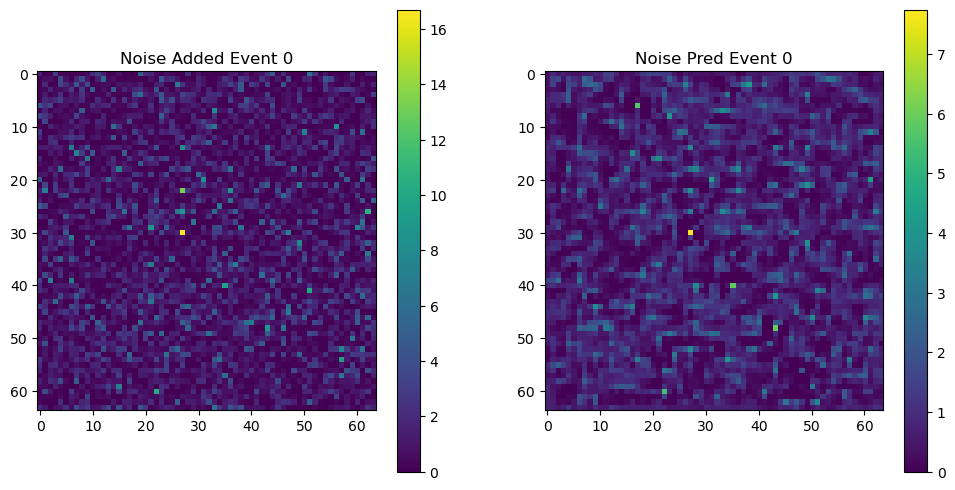

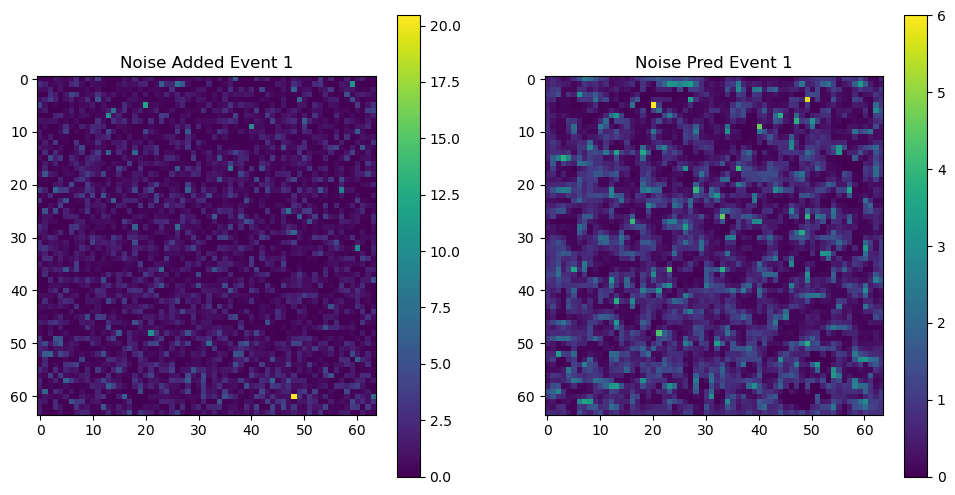

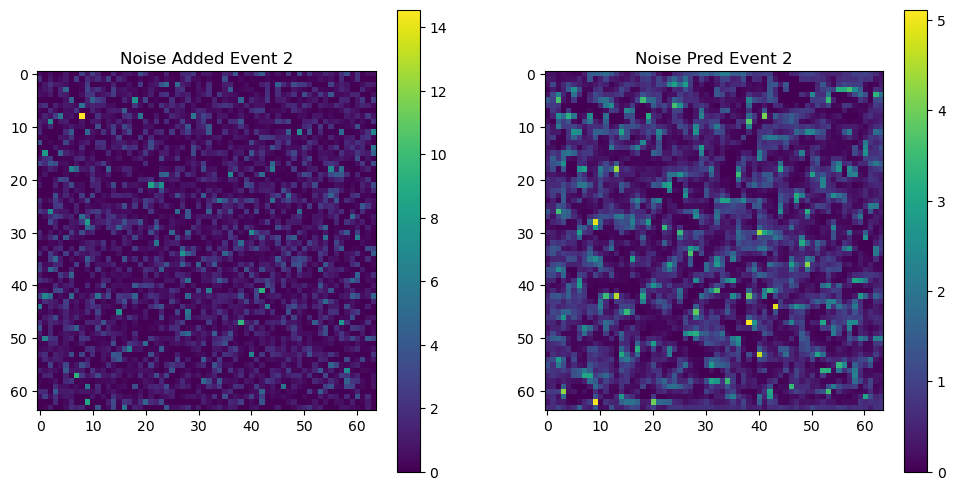

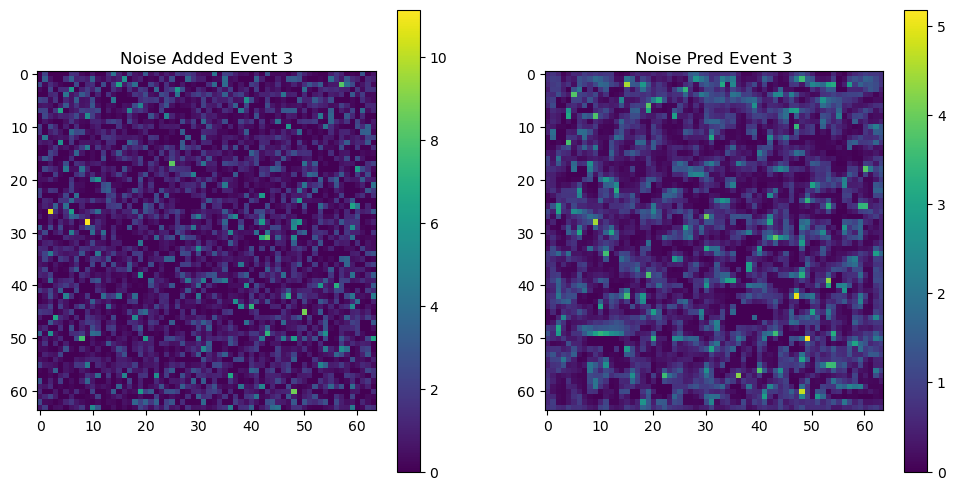

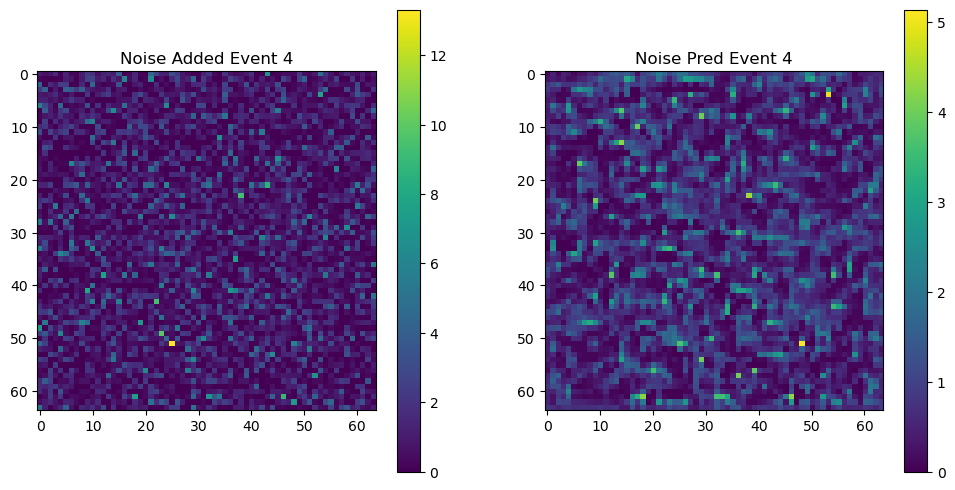

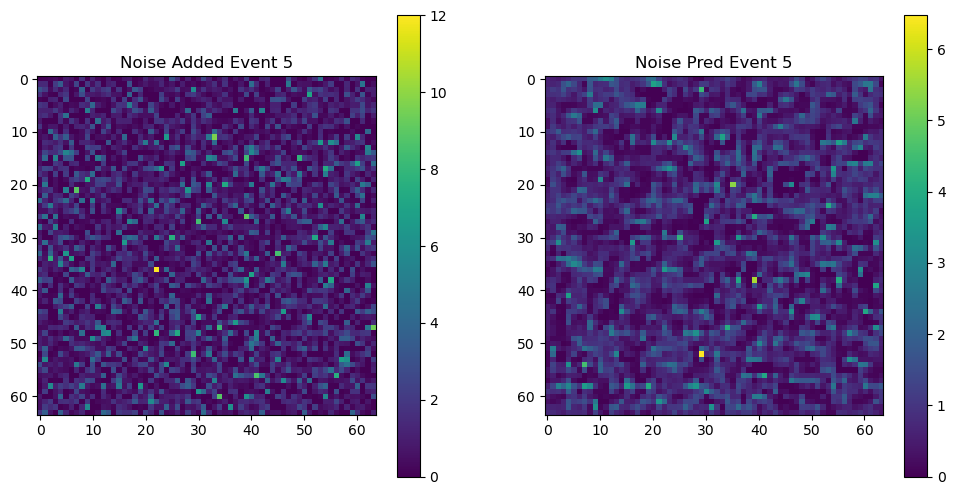

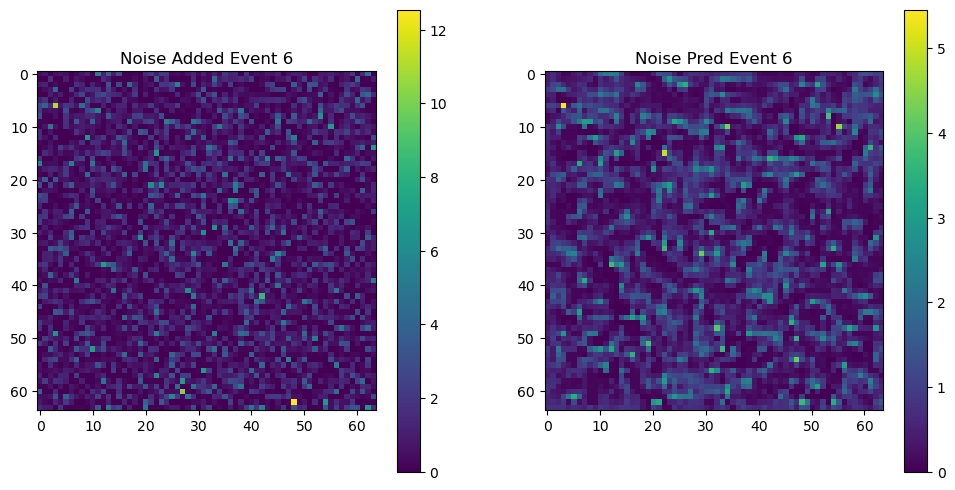

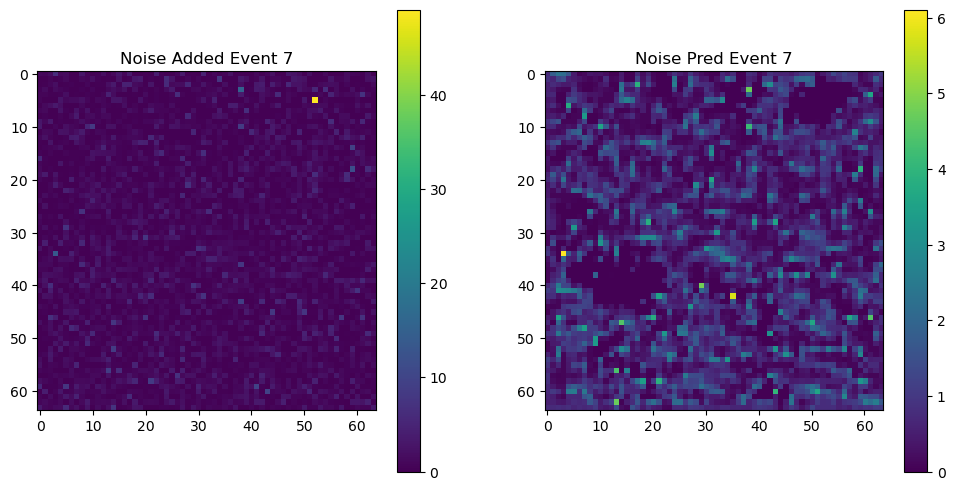

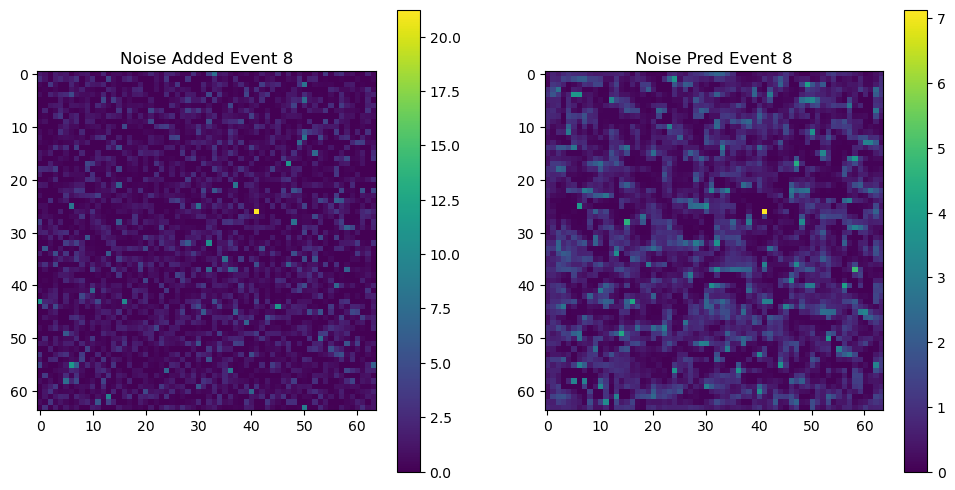

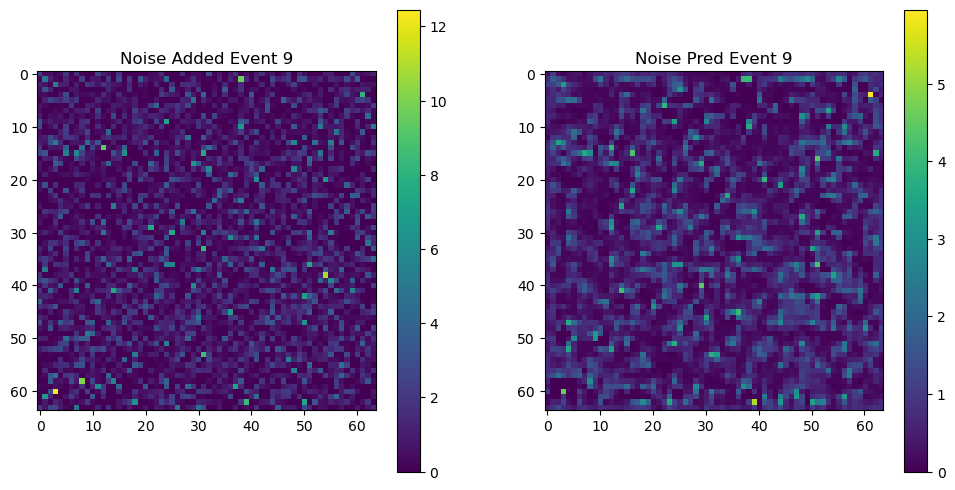

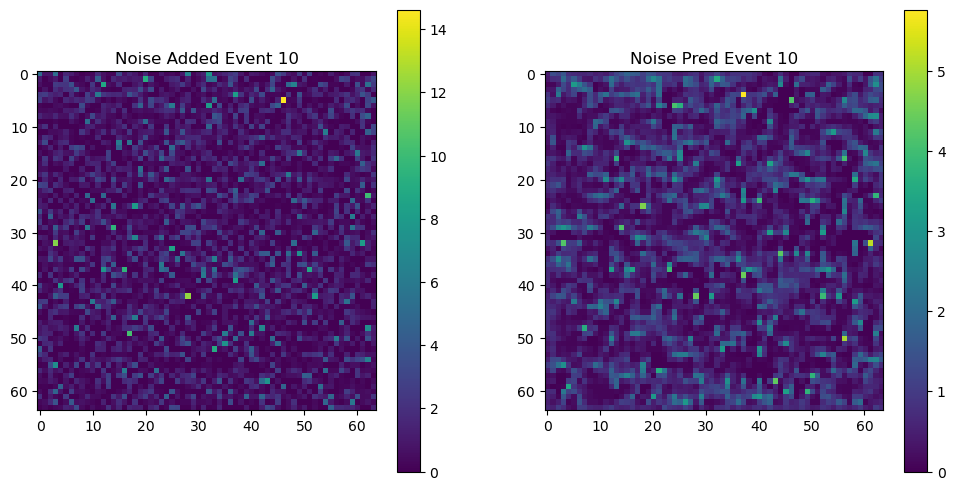

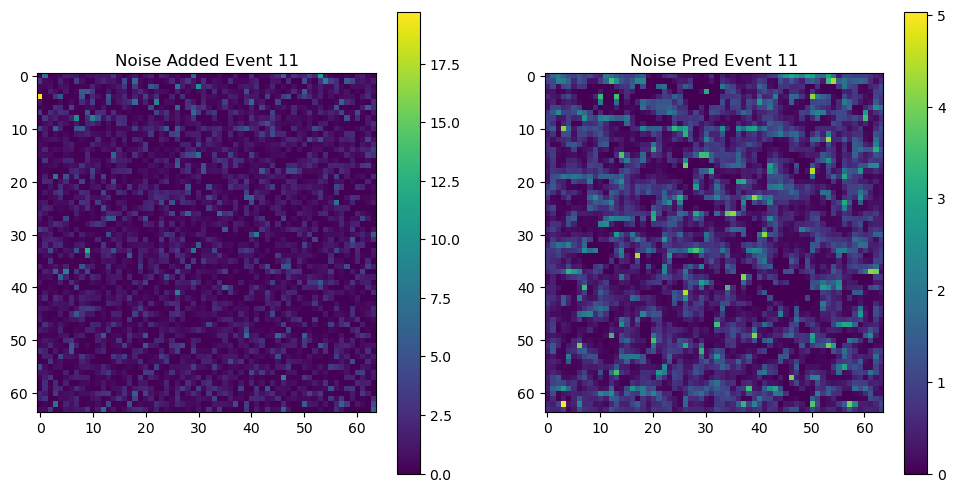

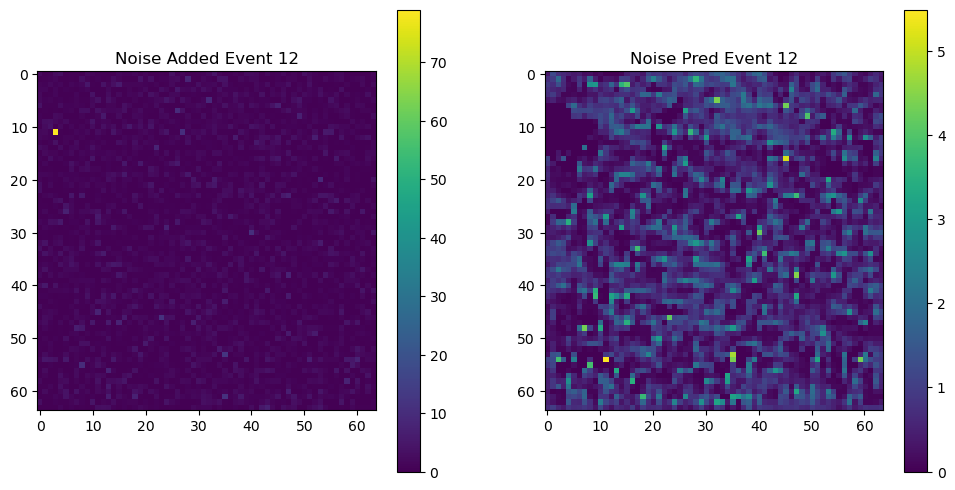

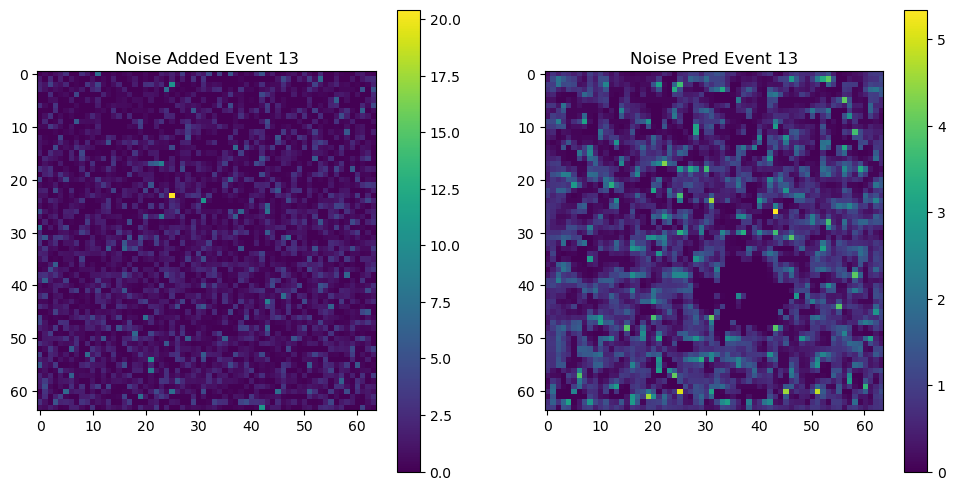

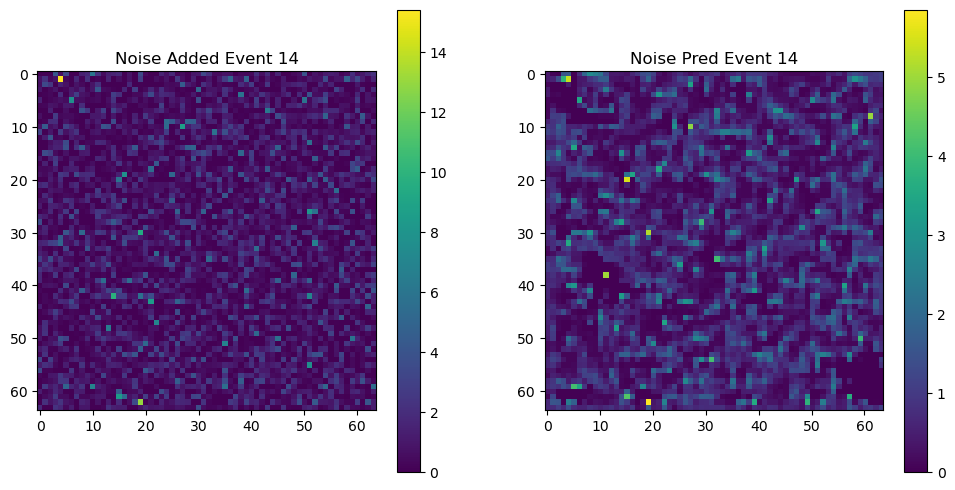

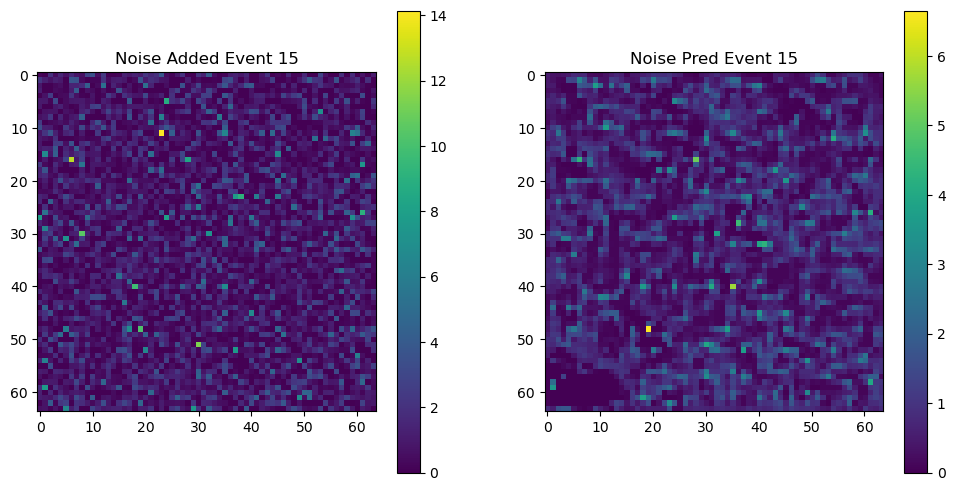

In [12]:
# Running the training loop
train_loop(config, model, pile_up, optimizer, dataloader, NoiseScheduler('pile-up'), num_events, loss_fn, saturation_value, modtype)